# Transfer learning: classifying food items

_Fraida Fund_


* Name: Yinhao Liu
* Net ID: yl11221

This week, we practiced using transfer learning to classify hand shapes as rock, paper, or scissors.

But that was a relatively easy problem. In this notebook, we'll work on classifying photographs of food items into 11 classes: bread, dairy product, dessert, egg, fried food, meat, noodles/pasta, rice, seafood, soup, and vegetable/fruit.

This is a more challenging problem, because there is a lot of intra-class variability (e.g. different fruits and vegetables don't have a lot in common) and also some inter-class similarity (e.g. a bowl of rice can look similar to a bown of pasta).

To see what we mean by these, let's look at some examples of food photographs from the dataset that we'll work with.



Note: you can refer to this week's demo notebook for a closely related example.

Note: you may want to change the notebook's runtime type to GPU, for faster model training.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

import tensorflow as tf

## Get data

We are going to use the [Food-11 dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/), from the EPFL Multimedia Signal Processing Group. Here's a description:

> This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. Similar as Food-5K dataset, the whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively.
>
> The total file size of the Food-11 dataset is about 1.16 GB.



In [ ]:
classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
	"Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
	"Vegetable/Fruit"])

In [ ]:
!mkdir -p /content/Food-11
%cd /content/Food-11
!gdown https://drive.google.com/uc?id=1dt3CD3ICdLbTf80sNJ25TPBDKu_qyCnq

/content/Food-11
Downloading...
From: https://drive.google.com/uc?id=1dt3CD3ICdLbTf80sNJ25TPBDKu_qyCnq
To: /content/Food-11/Food-11.zip
100% 1.16G/1.16G [00:07<00:00, 151MB/s]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip Food-11.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: training/2_787.jpg      
  inflating: training/2_924.jpg      
  inflating: training/5_453.jpg      
  inflating: training/10_212.jpg     
  inflating: training/9_962.jpg      
  inflating: training/3_433.jpg      
  inflating: training/3_922.jpg      
  inflating: training/1_359.jpg      
  inflating: training/5_1145.jpg     
  inflating: training/5_204.jpg      
  inflating: training/5_1046.jpg     
  inflating: training/7_160.jpg      
  inflating: training/10_635.jpg     
  inflating: training/0_879.jpg      
  inflating: training/9_313.jpg      
  inflating: training/1_131.jpg      
  inflating: training/10_448.jpg     
  inflating: training/9_1110.jpg     
  inflating: training/8_230.jpg      
  inflating: training/5_731.jpg      
  inflating: training/0_151.jpg      
  inflating: training/2_984.jpg      
  inflating: training/2_1335.jpg     
  inflating: training/4_745.jpg      
  inflating: training/6_236.jpg      
  inflating: training/9

In [ ]:
%cd /content

/content


Click on the folder icon in Colab to view your filesystem and verify that you have the `Food-11` directory with `training`, `validation`, and `evaluation` subdirectories.

In [ ]:
training_dir = "Food-11/training/"
training_images = os.listdir(training_dir)
training_labels = np.array([int(f.split('_')[0]) for f in training_images ])

In [ ]:
validation_dir = "Food-11/validation/"
validation_images = os.listdir(validation_dir)
validation_labels = np.array([int(f.split('_')[0]) for f in validation_images ])

In [ ]:
evaluation_dir = "Food-11/evaluation/"
evaluation_images = os.listdir(evaluation_dir)
evaluation_labels = np.array([int(f.split('_')[0]) for f in evaluation_images ])

Let's look at a few random training samples:

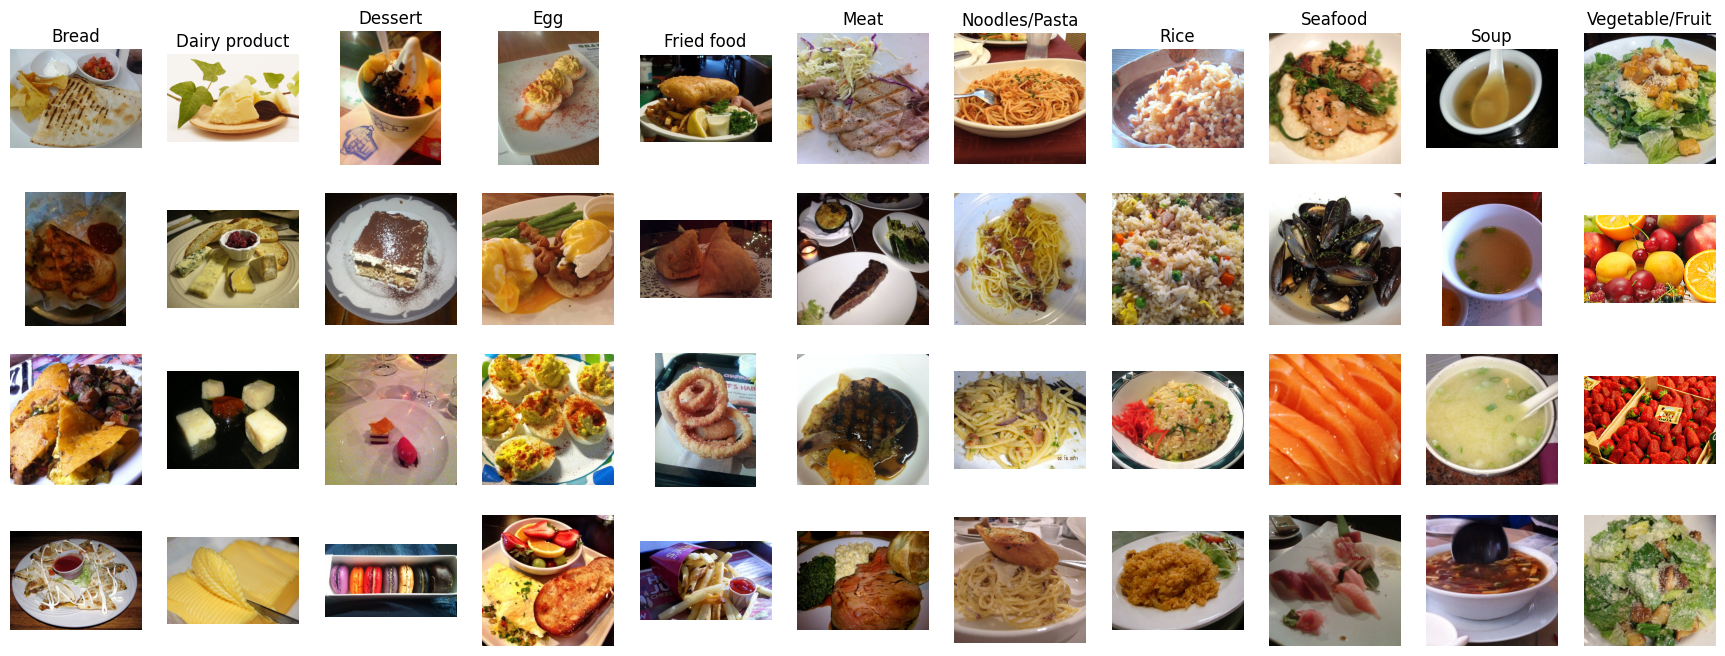

In [ ]:
num_classes = len(classes)
samples_per_class = 4
figure = plt.figure(figsize=(num_classes*2,samples_per_class*2))
for cls_idx, cls in enumerate(classes):
  idxs = np.flatnonzero(training_labels == cls_idx)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + cls_idx + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    im = Image.open(training_dir + training_images[idx])
    plt.imshow(im)
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

We can see that two dessert samples (for example) may look very different from one another - intra-class variability. Furthermore, samples from two different classes, such as a rice dish and a noodles dish, may look very similar to one another - inter-class similarity.

(In fact, some foods may really belong to multiple classes.  For example, fried chicken should really have both the "fried food" and "meat" labels, but only one class label is provided for each sample in the dataset.)

## Prepare data directories

Because the Food-11 dataset is very large, we won't want to load the entire dataset into memory at once.

Instead, Keras will let us read in images from disk as they are needed (in batches). For this to work, Keras [expects](https://keras.io/api/preprocessing/) that images will be organized in the following directory structure, with one subdirectory per class:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

So, we will have to re-organize our directory structure to match.

In [ ]:
%cd /content/Food-11/training/

# loop over classes
for i in range(len(classes)):
  # make a directory for this class inside Food-11/training
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  # get list of files inside Food-11/training that have this class label
  files = [f for f in os.listdir('/content/Food-11/training/') if f.startswith("%d_" % i)]
  # move each file to the subdirectory for the class
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/training


In [ ]:
%cd /content/Food-11/validation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/validation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/validation


In [ ]:
%cd /content/Food-11/evaluation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/evaluation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/evaluation


In [ ]:
# go back to default working directory
%cd /content

/content


Use the folder icon in Colab to look at your directory structure, and verify that within the training, validation, and evaluation data directories, there are subdirectories for each class containing the samples from that class.

## Prepare data generators

Now that we have prepared the directory structure, we can set up our data "flow".

In the next cell, I have defined a batch size and an image size. You are free to change these parameters, or you can keep them. You can use any batch size that has good results in training, and you can change the input image size to match the input shape of whatever base model you are using.

In [ ]:
# TODO 1 (optional) - design choice on batch size, image shape
BATCH_SIZE=32
INPUT_IMG_SIZE = 224

Then, I have defined some data generators to create augmented samples (slightly changed versions of the original samples). You are free to change the transformations used to generate the augmented data. You can learn more about the image transformations in the [ImageDataGenerator documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class).

After we define the data generator, we use  `flow_from_directory` to get images off the disk during training, on an as-needed basis.

In [ ]:
# TODO 2 (optional) - design choices on image transformations for data augmentation

# prepare ImageDataGenerator to create augmented training samples
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,          # rescales so each pixel is in 0-1 range
	rotation_range=1,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest")

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 9866 images belonging to 11 classes.


Check the mapping of directory names to class labels:

In [ ]:
training_gen.class_indices

{'class_00': 0,
 'class_01': 1,
 'class_02': 2,
 'class_03': 3,
 'class_04': 4,
 'class_05': 5,
 'class_06': 6,
 'class_07': 7,
 'class_08': 8,
 'class_09': 9,
 'class_10': 10}

We also set up the validation and evaluation (test) sets in a similar manner:

In [ ]:
validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

validation_gen = validation_aug.flow_from_directory(
	'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3430 images belonging to 11 classes.


Don't shuffle the evaluation set:

In [ ]:
evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

evaluation_gen = evaluation_aug.flow_from_directory(
	'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3347 images belonging to 11 classes.


## Prepare base model

Now that the data is ready, we need to prepare the model.


First, review the models available as [Keras Applications](https://keras.io/api/applications/), and decide which model you will use. Make sure to click through from the table to the model documentation, to learn more about each model you are considering.

In the cell that follows, I have used the [VGG16](https://keras.io/api/applications/vgg/) model, but you can change that - you may use any model that you think will have good results.

In [ ]:
# TODO 3 (optional) - design choice on base model

base_model = tf.keras.applications.ResNet101V2(
  input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
  include_top=False,
  pooling='avg'
)

171317808/171317808 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

## Train model with new classification head

In the following cell, "freeze" your base model (set it so that it is not trainable), and then construct a new model using the frozen base model with a new classification head.  (You can add a dropout layer in between if you think it will be helpful.)

(You can refer to this week's demo notebook for an example.)

In [ ]:
# TODO 4 (required) - prepare model with new classification head
# freeze base model
base_model.trainable = False

model = tf.keras.models.Sequential()
# add to your model here...
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

Then, print a model summary:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 11)                22539     
                                                                 
Total params: 42649099 (162.69 MB)
Trainable params: 22539 (88.04 KB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________


(Make sure that most parameters are "non-trainable", because you have frozen the base model!)

Compile your model with an appropriate optimizer and loss function, and use accuracy as a metric.

In [ ]:
# TODO 5 (required) - design training parameters, and compile

# model.compile(...)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Finally, fit your model with the new classification head for as many epochs as you think is appropriate. You may also use early stopping if you think it will be helpful.

Pass the validation data generator as `validation_data`.

(You can refer to this week's demo notebook for an example.)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# TODO 6 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs = ...
# hist = model.fit(...)

# Set early stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # If there is no improvement after 10 epochs, stop
    restore_best_weights=True  # Restore optimal model weights
)

# Set the number of training cycles
n_epochs = 20  #
# Training model
hist = model.fit(
    training_gen,
    steps_per_epoch=training_gen.n // BATCH_SIZE,
    epochs=n_epochs,
    validation_data=validation_gen,
    validation_steps=validation_gen.n // BATCH_SIZE,
    callbacks=[early_stopping]
)



Epoch 1/20
308/308 [==============================] - 191s 563ms/step - loss: 1.2088 - accuracy: 0.6229 - val_loss: 0.6875 - val_accuracy: 0.7795
Epoch 2/20
308/308 [==============================] - 171s 554ms/step - loss: 0.7707 - accuracy: 0.7454 - val_loss: 0.5974 - val_accuracy: 0.8096
Epoch 3/20
308/308 [==============================] - 170s 553ms/step - loss: 0.7208 - accuracy: 0.7617 - val_loss: 0.5829 - val_accuracy: 0.8172
Epoch 4/20
308/308 [==============================] - 171s 556ms/step - loss: 0.6598 - accuracy: 0.7830 - val_loss: 0.5699 - val_accuracy: 0.8140
Epoch 5/20
308/308 [==============================] - 172s 559ms/step - loss: 0.6569 - accuracy: 0.7850 - val_loss: 0.5750 - val_accuracy: 0.8213
Epoch 6/20
308/308 [==============================] - 170s 552ms/step - loss: 0.6409 - accuracy: 0.7873 - val_loss: 0.5947 - val_accuracy: 0.8148
Epoch 7/20
308/308 [==============================] - 175s 568ms/step - loss: 0.6359 - accuracy: 0.7960 - val_loss: 0.6007 -

Plot the training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot.

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

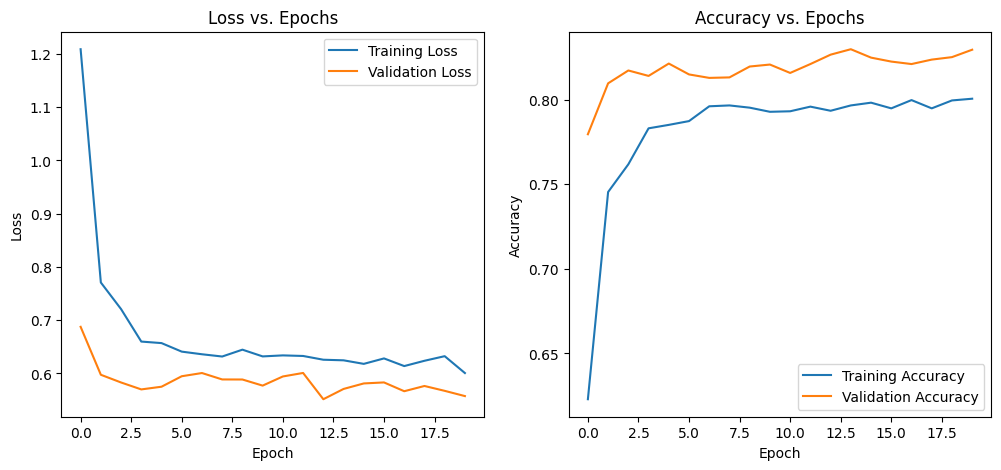

In [ ]:
# TODO 7 (required) - plot training history
# loss curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracy curve
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Fine-tune model

Next, we are going to "un-freeze" the later layers of the model, and train it for a few more epochs on our data (with a smaller learning rate), so that it is better suited for our specific classification task.

Note that you should *not* create a new model. We're just going to continue training the model we already started training.

First, we will un-freeze the base model:

In [ ]:
base_model.trainable = True

Then, we will re-freeze only the first layers of the base model. In the cell below, I have left the last five layers, which includes the last set of convolutional filters, unfrozen. But you are free to change this number if you think you will get better performance.

In [ ]:
len(base_model.layers)

378

In [ ]:
# TODO 8 (optional) - you can decide how many layers to unfreeze

for layer in base_model.layers[:-95]:
	layer.trainable = False

The output of the following cell will indicate which layers in the base model are trainable, and which are not:

In [ ]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x797fc0823eb0>: False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x797fc0879990>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x797fc0879fc0>: False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x797fc32a8100>: False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x797fc087b6a0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x797fc0c2c310>: False
<keras.src.layers.core.activation.Activation object at 0x797fc087b430>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x797fc087bdc0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x797fc0c2ebc0>: False
<keras.src.layers.core.activation.Activation object at 0x797fc0c2f250>: False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x797fc0c2d450>: False
<keras.src.layers.convolutional.conv2d.Conv2D ob

Also, the model summary should now show more trainable parameters:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 11)                22539     
                                                                 
Total params: 42649099 (162.69 MB)
Trainable params: 20847627 (79.53 MB)
Non-trainable params: 21801472 (83.17 MB)
_________________________________________________________________


Re-compile your model. Don't forget to use a smaller learning rate for fine-tuning! We don't want to make major changes to the last feature extraction layers, we just want to adjust them a little bit.

In [ ]:
# TODO 9 (required) - re-compile model
# use a smaller learning rate for fine-tuning

# model.compile(...)
# Recompile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Fit your model (with some newly unfrozen layers) for some more epochs.

In [ ]:
# TODO 10 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

# n_epochs_fine = ...
# hist_fine = model.fit(...)
# Set early stop again
early_stopping_fine = EarlyStopping(
    monitor='val_loss',
    patience=2,  #
    restore_best_weights=True
)

# Set the number of training cycles for fine-tuning
n_epochs_fine = 5  #

# Fine-tuning the model
hist_fine = model.fit(
    training_gen,
    steps_per_epoch=training_gen.n // BATCH_SIZE,
    epochs=n_epochs_fine,
    validation_data=validation_gen,
    validation_steps=validation_gen.n // BATCH_SIZE,
    callbacks=[early_stopping_fine]
)


Epoch 1/5
308/308 [==============================] - 214s 632ms/step - loss: 0.8269 - accuracy: 0.7330 - val_loss: 0.5757 - val_accuracy: 0.8180
Epoch 2/5
308/308 [==============================] - 205s 664ms/step - loss: 0.6148 - accuracy: 0.7887 - val_loss: 0.5226 - val_accuracy: 0.8370
Epoch 3/5
308/308 [==============================] - 208s 675ms/step - loss: 0.5090 - accuracy: 0.8266 - val_loss: 0.4932 - val_accuracy: 0.8464
Epoch 4/5
308/308 [==============================] - 206s 670ms/step - loss: 0.4440 - accuracy: 0.8502 - val_loss: 0.4698 - val_accuracy: 0.8548
Epoch 5/5
308/308 [==============================] - 207s 673ms/step - loss: 0.3818 - accuracy: 0.8714 - val_loss: 0.4571 - val_accuracy: 0.8598


Plot the complete training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot. Draw a vertical line demarcating the first stage of training (training the classification head) and the second stage of training (fine tuning).

(You can refer to this week's demo notebook for an example.)

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist_fine = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

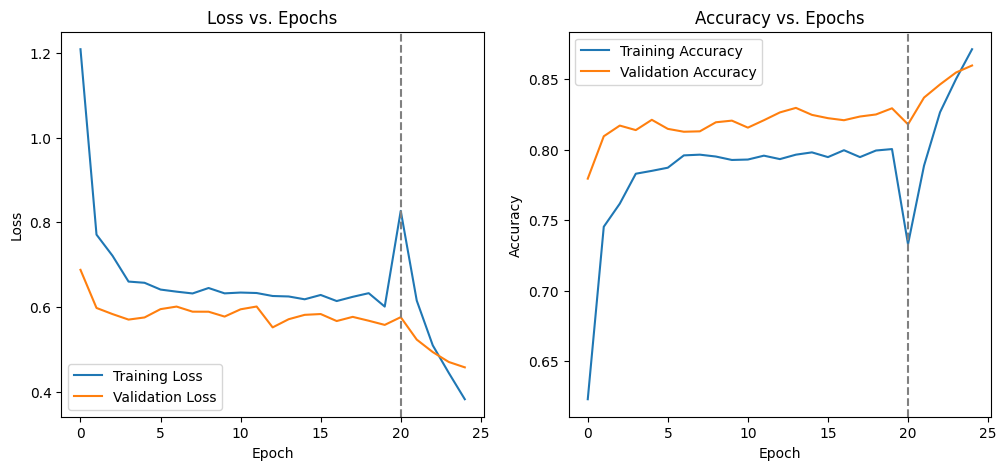

In [ ]:
# TODO 11 (required) - plot training history
# Merge the history of two stages
total_loss = hist.history['loss'] + hist_fine.history['loss']
total_val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']
total_accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
total_val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

# Calculate the number of epochs in the initial training phase
initial_epochs = len(hist.history['loss'])

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# loss curve
plt.subplot(1, 2, 1)
plt.plot(total_loss, label='Training Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs, color='gray', linestyle='--')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracy curve
plt.subplot(1, 2, 2)
plt.plot(total_accuracy, label='Training Accuracy')
plt.plot(total_val_accuracy, label='Validation Accuracy')
plt.axvline(x=initial_epochs, color='gray', linestyle='--')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluate model performance


Once you have finished training your model, use `evaluate` to get the model performance - loss and accuracy - on the evaluation set. (You should not use the evaluation set at all prior to this step.)

In [ ]:
model.evaluate(evaluation_gen)

105/105 [==============================] - 19s 183ms/step - loss: 0.3774 - accuracy: 0.8787


[0.377367228269577, 0.8786973357200623]

We can also create a confusion matrix, to see which which classes are most often confused with one another.

In [ ]:
y_pred_prob = model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

105/105 [==============================] - 23s 192ms/step


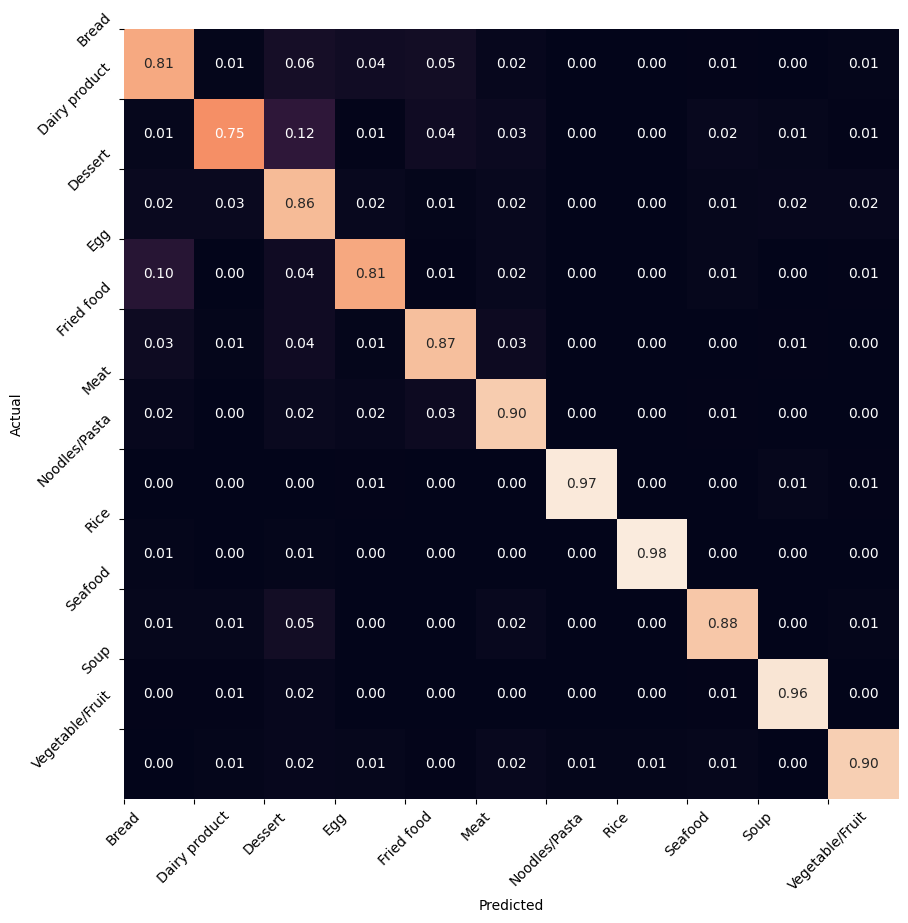

In [ ]:
cm = pd.crosstab(evaluation_gen.classes, y_pred,
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11), labels=classes, rotation=45)

## Save your model

Use the following cell to save your model:

In [ ]:
model.save("model.keras")

Then, download it for later use.

In [ ]:
from google.colab import files
files.download('model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Use model on your own custom image

Take your own photograph of a food item in one of the 11 classes. Upload it to Colab, load it as a numpy array, and process the image (resize it, and scale so that each pixel takes on a value from 0 to 1).

Then, use the fitted model to get the per-class probabilities for each class.


Plot your image, and a bar plot showing the probability for the 5 most likely classes according to the model.

(You can refer to the "Classify with MobileNetV2" section of this week's notebook for an example.)

In [ ]:
# TODO 12 (required) - show example of model use on a new image
# Load and preprocess images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
uploaded_img_path = '/content/egg1.jpeg'  # Replace with your image path
img = load_img(uploaded_img_path, target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
img_array = img_to_array(img) / 255.0  # Normalized
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension to images


In [ ]:
preds = model.predict(img_array)

# Get the top 5 most likely categories
top_5_pred_indices = preds[0].argsort()[-5:][::-1]
top_5_pred_values = preds[0][top_5_pred_indices]
top_5_pred_labels = classes[top_5_pred_indices]

1/1 [==============================] - 3s 3s/step


In [ ]:
top_5_pred_values

array([9.9999750e-01, 2.1143430e-06, 1.7484251e-07, 1.1731108e-07,
       8.7755510e-08], dtype=float32)

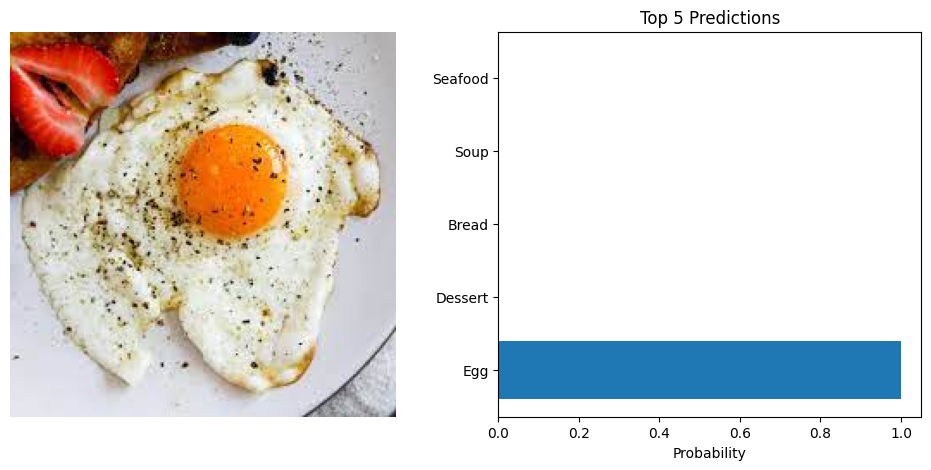

In [ ]:
# Plot images and forecast bar charts
plt.figure(figsize=(12, 5))

# draw image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

# Draw a bar chart
plt.subplot(1, 2, 2)
plt.barh(top_5_pred_labels, top_5_pred_values)
plt.xlabel('Probability')
plt.title('Top 5 Predictions')
plt.show()

## Describe your model - TODO 13 (required)

In the following cell, describe your final model and your results, by answering the following questions.

* What base model did you use? How many parameters does this base model have?
* Describe the specific transformations you used to create an augmented data set.
* For how many epochs did you train your classification head, and with what optimizer, learning rate, and batch size? What was the validation accuracy at the end of this training stage?
* Which layers did you un-freeze for fine-tuning, how many epochs did you fine-tune for, and what optimizer, learning rate, and batch size did you use for fine-tuning? What was the validation accuracy at the end of this training stage?
* What was your final accuracy on the evaluation set?
* Did your model correctly predict the class of your custom test image?